In [30]:
def getTripFareEst(pu_location_id, do_location_id, time_of_day):
    data = {}
    for tt in [GREEN, YELLOW]:
        df = getCachedSql(PU_DO_TIME_AVGS_CACHE, tt)
    
        df = df.groupby(["pu_location_id", "do_location_id", "time_of_day"])['avg_fare_amount'].mean().reset_index()
        df = df[(df['pu_location_id'] == pu_location_id )
                            & (df['do_location_id'] == do_location_id )
                            & (df['time_of_day'] == time_of_day )]
        
        data[tt] = df
        print(df)

    if len(data[GREEN]) == 0 and len(data[YELLOW]) == 0:
        return '''
            Neither Green nor Yellow taxis are available for such trips. 
        '''
    elif len(data[GREEN]) == 0:
        yfa = data[YELLOW]['avg_fare_amount'].iloc[0]
        return f'''
            Yellow Taxis will be available for this trip.
            Expect the fare amount to be ~{yfa:.2f}
        '''
    elif len(data[YELLOW]) == 0:
        gfa = data[GREEN]['avg_fare_amount'].iloc[0]
        return f'''
            Green Taxis will be available for this trip.
            Expect the fare amount to be ~{gfa:.2f}
        '''
    else:
        gfa = data[GREEN]['avg_fare_amount'].iloc[0]
        yfa = data[YELLOW]['avg_fare_amount'].iloc[0]
        if gfa < yfa:
            return f'''
                Green Taxis should be preferred over Yellow for this trip as they offer lower fares.
                Expect the fare amount to be ~{gfa:.2f}
            '''
        else:
            return f'''
                Yellow Taxis should be preferred over Green for this trip as they offer lower fares.
                Expect the fare amount to be ~{yfa:.2f}
            '''
    

In [38]:
import random

pu, do = random.randint(1, 250), random.randint(1, 250)

print(f'pu: {pu}, do: {do}')

getTripFareEst(pu, do, 'Morning')


pu: 231, do: 80
Empty DataFrame
Columns: [pu_location_id, do_location_id, time_of_day, avg_fare_amount]
Index: []
        pu_location_id  do_location_id time_of_day  avg_fare_amount
117370             231              80     Morning        21.519265


'\n            Yellow Taxis will be available for this trip.\n            Expect the fare amount to be ~21.52\n        '

In [ ]:
from model import *
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

LINEAR_REGRESSION = 'linear_regression'
RANDOM_FOREST = 'random_forest'
GRADIENT_BOOST = 'gradient_boost'
XGB_REGRESSOR = 'xgb_regressor'
LIGHT_GBM_REGRESSOR = 'light_gbm_regressor'
RIDGE = 'ridge'
NEURAL_NETWORK = 'neural_network'

# model list = list of tuples (name, features, variable, suffix)
model_list = [
    (LINEAR_REGRESSION, FEATURES, VARIABLE, ''),
    (RANDOM_FOREST, FEATURES, VARIABLE, ''),
    (GRADIENT_BOOST, FEATURES, VARIABLE, ''),
    (XGB_REGRESSOR, FEATURES, VARIABLE, ''),
    (LIGHT_GBM_REGRESSOR, FEATURES, VARIABLE, ''),
    (RIDGE, FEATURES, VARIABLE, ''),
    (NEURAL_NETWORK, FEATURES, VARIABLE, ''),
]

def initModel(model_name, features):
    if model_name == LINEAR_REGRESSION:
        return LinearRegression()
    elif model_name == RANDOM_FOREST:
        return RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    elif model_name == GRADIENT_BOOST:
        return GradientBoostingRegressor(n_estimators=500, 
                                        learning_rate=0.1,
                                        n_iter_no_change=10, 
                                        max_depth=3, 
                                        random_state=42)
    elif model_name == XGB_REGRESSOR:
        return XGBRegressor(n_estimators=1000, 
                            learning_rate=0.1, 
                            n_iter_no_change=10,
                            max_depth=9)
    elif model_name == LIGHT_GBM_REGRESSOR:
        return LGBMRegressor(n_estimators=1000, 
                            learning_rate=0.5, 
                            max_depth=9)
    elif model_name == RIDGE:
        return Ridge(alpha=1, solver='auto')
    elif model_name == NEURAL_NETWORK:
        model = Sequential([
            Dense(64, input_dim=len(features), activation="relu"),  # Input layer + first hidden layer
            Dropout(0.2),  # Dropout for regularization
            Dense(32, activation="relu"),  # Second hidden layer
            Dropout(0.2),  # Dropout for regularization
            Dense(16, activation="relu"),  # Third hidden layer
            Dense(1)  # Output layer for regression
        ])

        # Compile the model
        model.compile(optimizer="adam", loss="mse", metrics=["mae"])
        return model

def fitModel(model_name, model, data, features, variable):
    X = data[features]
    y = data[variable]

    if model_name == NEURAL_NETWORK:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

        model.fit(
            X_train_scaled, y_train,
            validation_data=(X_test_scaled, y_test),
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping],
            verbose=1
        )
    else:
        model.fit(X, y)
        

# build and store models
# ----- DONT USE THIS AS IS ----- 
def buildAndStoreModels(taxi_type, model_name):
    model = initModel(model_name, FEATURES)

    chunks = 0
    columns = COMMON_FETCH_COLUMNS + ['time_of_day', 'day_of_week']
    
    for year in range(MIN_YEAR, MAX_YEAR + 1):
        sql = text(f"""
            {selFrom(columns, year, taxi_type)}
            where {' AND '.join(commonConditions(year))}
        """)

        with DR.engn.connect() as conn:
            for df in pd.read_sql(sql, conn, chunksize=CHUNK_SIZE):
                df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
                chunks += len(df)
                O.out(f'data processed: {chunks}')

                for (model_name, features, variable, suffix) in model_list:
                    fitModel(model_name, models[model_name], df, features, variable)
            O.out(SEPARATOR)

    for (model_name, features, variable, suffix) in model_list:
        storeModel(models[model_name], f'{taxi_type}_{variable}_{model_name}{suffix}')

In [ ]:
import plotly.graph_objs as go

def predictModel(model_name, model, X):
    if model_name == NEURAL_NETWORK:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        y_pred = model.predict(X_scaled)
        return y_pred.flatten()
    else:
        return model.predict(X)
    
def goLinePlot(title, x_label, y_label, x, y1, y2):
    fig_lr = go.Figure()
    sample_size = 150
    y1_sample = y1[:sample_size].reset_index(drop=True)
    y2_sample = y2[:sample_size]

    fig_lr.add_trace(go.Scatter(x=x, y=y1_sample, mode='lines+markers', name="Actual", line=dict(color='blue')))
    fig_lr.add_trace(go.Scatter(x=x, y=y2_sample, mode='lines+markers', name="Predicted", line=dict(color='orange')))
    fig_lr.update_layout(
        title=title,
        xaxis_title=x_label,
        yaxis_title=y_label,
        legend=dict(x=0, y=1.1, orientation="h"),
        margin=dict(l=5, r=5, t=70, b=5)
    )
    return fig_lr


def buildModelComparison(taxi_type):
    result = []
    figures = []
    data = getSample(year=2020, taxi_type=taxi_type, limit=30000)
    for (model_name, features, variable, suffix) in model_list:
        X = data[features]
        y = data[variable]

        model = loadModel(f'{taxi_type}_{variable}_{model_name}{suffix}')
        y_pred = predictModel(model_name, model, X)

        result.append([model_name]+errors(y, y_pred))
        fig = goLinePlot(f'{model_name} Prediction', 'Index', variable, y.index, y, y_pred)
        figures.append(fig)

    return result, figures

def plotTable(df):
    # Create Plotly Table
    fig = go.Figure(
        data=[
            go.Table(
                header=dict(
                    values=list(df.columns),  
                    fill_color="lightgrey",  
                    align="center",          
                    font=dict(size=12, color="black")
                ),
                cells=dict(
                    values=[df[col] for col in df.columns], 
                    fill_color="white",                     
                    align="left",                           
                    font=dict(size=11)                      
                )
            )
        ]
    )

    fig.update_layout(title="Taxi Trip Data Table", title_x=0.5,
                      margin=dict(l=10, r=10, t=40, b=10),
                      height = 250) 
    fig.show()

def plotResult(taxi_type):
    r, f = buildModelComparison(taxi_type)
    res_df = pd.DataFrame(data=r, columns=['model_name', 'r2', 'mae', 'rmse', 'mape'])
    res_df = res_df.drop('mape', axis=1)
    plotTable(res_df)
    for fig in f:
        fig.show()


In [ ]:
buildAndStoreModels(GREEN)

In [ ]:
plotResult(GREEN)

In [ ]:

green_result_df = pd.DataFrame(
    data = [
        ['linear_regression', 0.82, 3.09, 4.95],
        ['random_forest', 0.93, 0.95, 2.97],
        ['gradient_boost', 0.94, 0.96, 2.82],
        ['xgb_regressor', 0.94, 0.86, 2.85],
        ['light_gbm_regressor', 0.94, 0.94, 2.87],
        ['ridge', 0.82, 3.09, 4.95],
        # ['neural_network', 0.89, 1.94, 3.82],
    ],
    columns=['model_name', 'r2', 'mae', 'rmse']
)


yellow_result_df = pd.DataFrame(
    data = [
        ['linear_regression', 0.95, 1.28, 3.14],
        ['random_forest', 0.98, 0.72, 2.25],
        ['gradient_boost', 0.97, 0.80, 2.35],
        ['xgb_regressor', 0.98, 0.61, 2.24],
        ['light_gbm_regressor', 0.98, 0.72, 2.27],
        ['ridge', 0.95, 1.28, 3.14],
        # ['neural_network', 0, 0, 0],
    ],
    columns=['model_name', 'r2', 'mae', 'rmse']
)

Mean Absolute Error (MAE): 0.80
Root Mean Squared Error (RMSE): 2.35
R-squared (Accuracy): 0.97

In [40]:
from lib import *
normalizedColumns = {
    'lpep_pickup_datetime': 'pickup_datetime', 'tpep_pickup_datetime': 'pickup_datetime',
    'lpep_dropoff_datetime': 'dropoff_datetime', 'tpep_dropoff_datetime': 'dropoff_datetime',
    'RatecodeID': 'ratecode_id',
    'PULocationID': 'pu_location_id', 
    'DOLocationID': 'do_location_id',
    'passenger_count': 'passenger_count', 
    'trip_distance': 'trip_distance', 
    'fare_amount': 'fare_amount', 
    'extra': 'extra', 
    'mta_tax': 'mta_tax',
    'tip_amount': 'tip_amount', 
    'tolls_amount': 'tolls_amount', 
    'improvement_surcharge': 'improvement_surcharge',
    'total_amount': 'total_amount', 
    'payment_type': 'payment_type', 
    'congestion_surcharge': 'congestion_surcharge'
}

for k in set(normalizedColumns.values()):
    O.out(k)

In [41]:
import pandas as pd

# Sample data for feature importance
data = {
    "Feature": ["age", "NIHSS", "sex", "cardiac history", "diabetes", "hypercholesterolemia", "thrombolysis treatment"],
    "GLM": [0.5, 0.6, 0.3, 0.2, 0.1, 0.05, 0.2],
    "Lasso": [0.4, 0.5, 0.2, 0.1, 0.05, 0.02, 0.1],
    "Elastic Net": [0.6, 0.7, 0.35, 0.15, 0.08, 0.03, 0.12],
    "Tree Boosting": [0.7, 0.8, 0.4, 0.3, 0.15, 0.1, 0.25],
    "MLP": [0.6, 0.7, 0.5, 0.25, 0.2, 0.1, 0.3]
}

df = pd.DataFrame(data)

import plotly.graph_objects as go

# Initialize a Plotly figure
fig = go.Figure()

# List of models to iterate through
models = ["GLM", "Lasso", "Elastic Net", "Tree Boosting", "MLP"]

# Create a subplot for each model
for i, model in enumerate(models):
    fig.add_trace(
        go.Bar(
            y=df["Feature"],                # Features on the y-axis
            x=df[model],                    # Importance values on the x-axis
            orientation="h",                # Horizontal bar chart
            name=model,                     # Model name for the legend
            marker=dict(color=f"rgba({20*i + 100}, {200 - 30*i}, {50*i + 100}, 0.7)")  # Custom color for each model
        )
    )

# Update layout for a clean look
fig.update_layout(
    title="Clinical Features Importance Rating",
    title_x=0.5,  # Center the title
    barmode="group",  # Group the bars side-by-side
    xaxis_title="Importance Score",
    yaxis_title="Features",
    template="plotly_white",
    legend=dict(orientation="h", y=-0.2, x=0.5, xanchor="center")  # Place the legend below the chart
)

# Show the chart
fig.show()


In [2]:
from data import *
import matplotlib.pyplot as plt
import seaborn as sns

taxi_type = YELLOW
# df = readData(taxi_type=taxi_type)
# df = df[[VARIABLE] + FEATURES]

sql engine ready


In [9]:
# Initialize an empty DataFrame to store correlations
correlation_sum = None
row_count = 0

# Target column for correlation
target_column = VARIABLE

# Process the file in chunks
for year in range(MIN_YEAR, MAX_YEAR + 1):
    all_conditions = commonConditions(year)
    where_clause = f'''where {' AND '.join(all_conditions)}''' 

    sql = text(f"""
        {selFrom([VARIABLE] + FEATURES, year, taxi_type)} {where_clause}
    """)
    
    with DR.engn.connect() as conn:
        for chunk in pd.read_sql(sql, conn, chunksize=CHUNK_SIZE):
            # chunk = chunk.dropna(subset=[target_column])
            chunk = chunk.dropna()
            
            # correlations = chunk.corr()[target_column] 
            chunk_corr = chunk.corr()
            
            if correlation_sum is None:
                correlation_sum = chunk_corr * len(chunk)  # Weighted sum of correlations
            else:
                correlation_sum += chunk_corr * len(chunk)  # Weighted sum

            # Update the total number of rows processed
            row_count += len(chunk)
    print(f'total_rows: {row_count}')


final_corr = correlation_sum / row_count
# average_correlation = average_correlation.drop(target_column)

# Display the result
# print("Average Correlations with 'fare_amount':")
# print(average_correlation.sort_values(ascending=False))

total_rows: 22573683
total_rows: 50228376
total_rows: 85998814
total_rows: 120393705


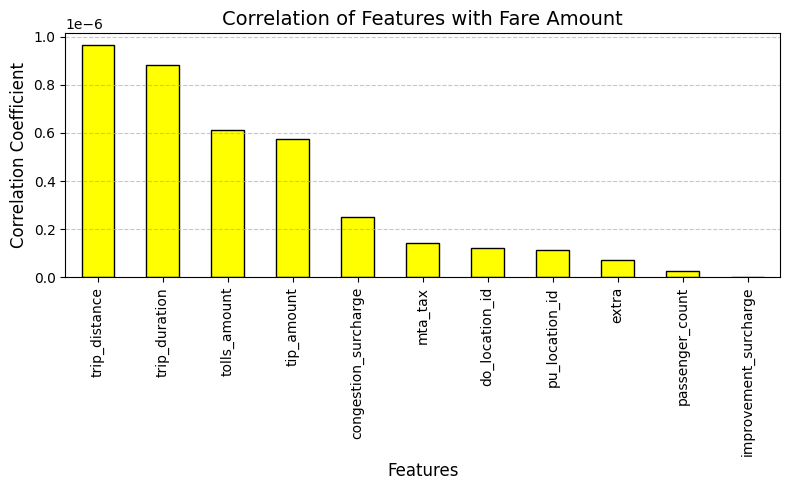

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate correlations with 'fare_amount'
# correlations = df.corr()["fare_amount"].drop("fare_amount")  # Exclude self-correlation

# Sort correlations by absolute values for better visualization
correlations = average_correlation.abs().sort_values(ascending=False)

# Plot bar chart
plt.figure(figsize=(8, 5))
correlations.plot(kind="bar", color=taxi_type, edgecolor="black")
plt.title("Correlation of Features with Fare Amount", fontsize=14)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.xlabel("Features", fontsize=12)
# plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


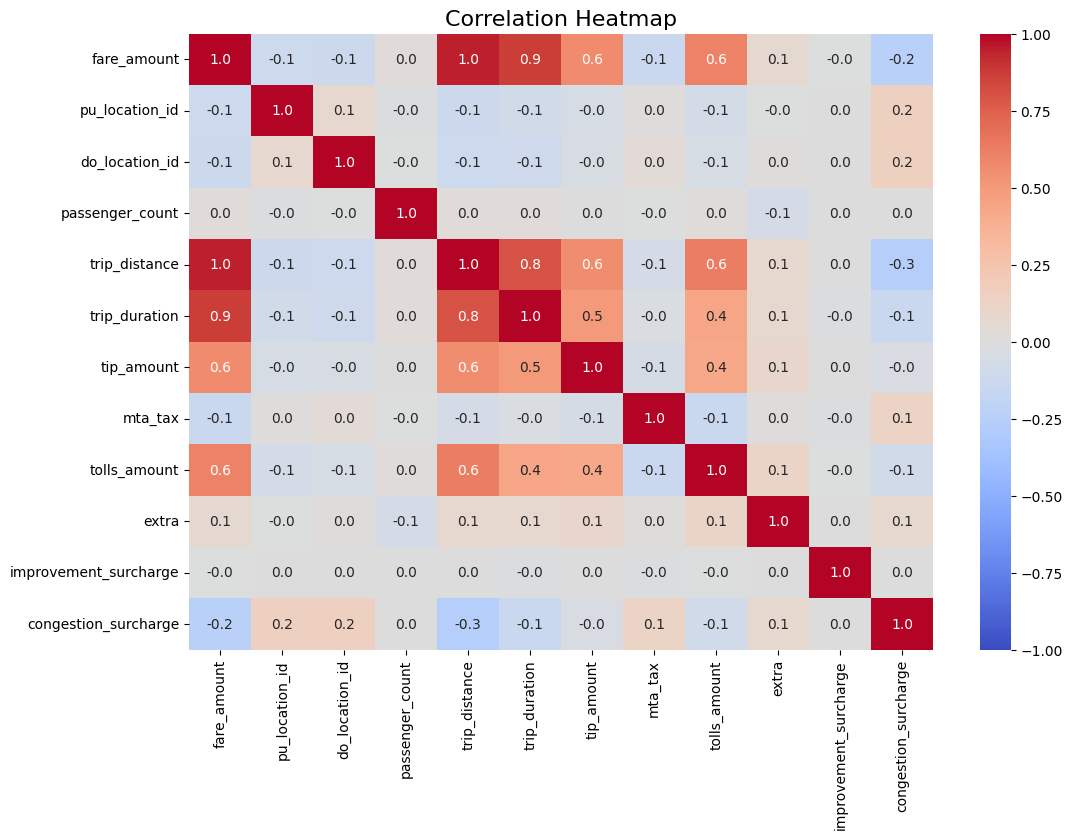

In [10]:
# corr_matrix = df[[VARIABLE] + FEATURES].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a heatmap
sns.heatmap(final_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.1f')

# Add titles and labels
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

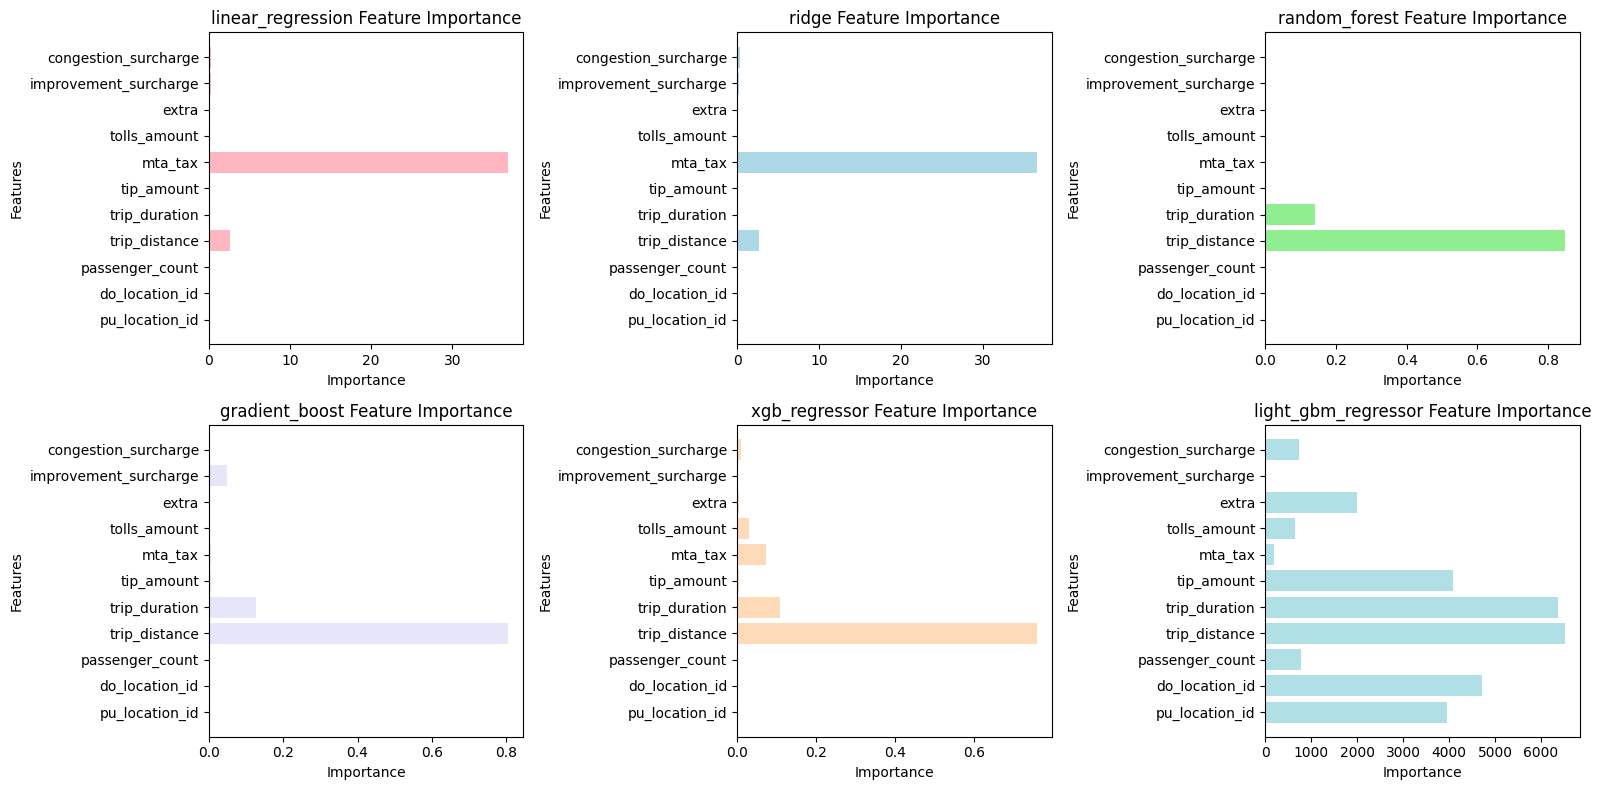

In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import shap
import matplotlib.pyplot as plt

from lib import *
from model import *
from data import *

taxi_type = YELLOW
train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)

# Feature selection and target variable
features = FEATURES
target = VARIABLE

model_names = [
    LINEAR_REGRESSION,
    RIDGE,
    RANDOM_FOREST,
    GRADIENT_BOOST,
    XGB_REGRESSOR,
    LIGHT_GBM_REGRESSOR,
]

color_list = [
    "lightpink",
    "lightblue",
    "lightgreen",
    "lavender",
    "peachpuff",
    "powderblue"
]

# Train models and calculate feature importance
feature_importances = {}
for name in model_names:
    model = loadModel(f'{taxi_type}_{VARIABLE}_{name}')
    
    # with DR.engn.connect() as conn:
    #     processed = 0
    #     y_t_chunks = []
    #     y_p_chunks = []
    #     for df in pd.read_sql(test_sql, conn, chunksize=CHUNK_SIZE):
    #         processed += len(df)
    #         X = df[FEATURES]
    #         y_t_chunks.append(df[VARIABLE])

    #         y_p_chunks.append(model.predict(X))
    #         O.out(f'Predicted {processed} rows')

    # # Performance
    # y_test = pd.concat(y_t_chunks, ignore_index=True)
    # y_pred = np.concatenate(y_p_chunks)
    
    # Feature importance
    if name == LINEAR_REGRESSION or name == RIDGE:
        # Coefficients as feature importance
        importance = np.abs(model.coef_)
    else:
        # Feature importance from tree-based models
        importance = model.feature_importances_
    
    feature_importances[name] = importance

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame(feature_importances, index=features)
# print(feature_importance_df)

# Plot feature importance for all models
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for idx, (name, importance) in enumerate(feature_importances.items()):
    axes[idx].barh(features, importance, color=color_list[idx])
    axes[idx].set_title(f"{name} Feature Importance")
    axes[idx].set_xlabel('Importance')
    axes[idx].set_ylabel('Features')

plt.tight_layout()
plt.show()

# SHAP values for XGBoost (example)
# print("Calculating SHAP values for XGBoost...")
# explainer = shap.TreeExplainer(models["XGBoost"])
# shap_values = explainer.shap_values(X_test)

# # SHAP summary plot
# shap.summary_plot(shap_values, X_test, plot_type="bar")

In [46]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Sample data
data = {
    "Feature": ["age", "NIHSS", "sex", "cardiac history", "diabetes", "hypercholesterolemia", "thrombolysis treatment"],
    "GLM": [0.5, 0.6, 0.3, 0.2, 0.1, 0.05, 0.2],
    "Lasso": [0.4, 0.5, 0.2, 0.1, 0.05, 0.02, 0.1],
    "Elastic Net": [0.6, 0.7, 0.35, 0.15, 0.08, 0.03, 0.12],
    "Tree Boosting": [0.7, 0.8, 0.4, 0.3, 0.15, 0.1, 0.25],
    "MLP": [0.6, 0.7, 0.5, 0.25, 0.2, 0.1, 0.3]
}
df = pd.DataFrame(data)

# Create subplots (one per model)
models = ["GLM", "Lasso", "Elastic Net", "Tree Boosting", "MLP"]
fig = make_subplots(
    rows=1, cols=len(models),  # One row, one column per model
    shared_yaxes=True,  # Share the y-axis (features)
    horizontal_spacing=0.1,  # Adjust spacing between subplots
    subplot_titles=models  # Model names as titles
)

# Add a bar chart for each model
for i, model in enumerate(models, start=1):
    fig.add_trace(
        go.Bar(
            x=df[model],  # Importance values
            y=df["Feature"],  # Features
            orientation="h",  # Horizontal bar chart
            name=model
        ),
        row=1, col=i
    )

# Update layout
fig.update_layout(
    title="Clinical Features Importance Rating",
    title_x=0.5,  # Center the title
    height=500,  # Adjust height for better readability
    showlegend=False,  # Hide legend
    template="plotly_white"
)

# Show the chart
fig.show()
